In [1]:
from utilities.io_tools import input_tools
from utilities.styles import styles
from utilities import common

from wremnants import plot_tools
import matplotlib as mpl
from matplotlib import cm
from matplotlib.colors import LogNorm
from matplotlib import pyplot as plt

import numpy as np
from utilities import boostHistHelpers as hh
import mplhep as hep
from wremnants import histselections as sel

colors = mpl.colormaps["tab10"]

Welcome to JupyROOT 6.30/02


In [2]:
output_dir = "/eos/home-d/dwalter/www/WMassAnalysis/240116_closure_fakes/"
histograms = "/eos/user/c/cmsmwbot/ScheduledBuilds/999d40bf-8eb7-4e04-9684-afa6899b7e36/mw_with_mu_eta_pt.hdf5"

In [3]:
res, meta, _ = input_tools.read_infile(histograms)

In [4]:
# load histograms
hQCD = res["QCDmuEnrichPt15PostVFP"]["output"]["nominal"].get()

In [5]:
hQCDFake = sel.fakeHistABCD(hQCD, fakerate_integration_axes=["eta","charge"])
hQCDSig = sel.signalHistWmass(hQCD)

In [6]:
hQCDFake_pt = hQCDFake.project("pt")
hQCDSig_pt = hQCDSig.project("pt")

In [7]:
from scipy.optimize import curve_fit

def exp_fall(x, a, b, c):
    return a * np.exp(-b * x) + c

In [8]:
def plot(hss, labels, linestyles=None, h1ds_nom=None, ratio=True, flow=False, showFlow=False, vars=["pt"], name="", 
         fit=True, variances=False):

    if linestyles is None:
        linestyles = ["-"]*len(labels)
    
    if h1ds_nom is not None:
        hs = [*hss, *h1ds_nom]
        hr = [*[hh.divideHists(h1d, hss[0]) for h1d in hss], *[hh.divideHists(h1d, h1ds_nom[0]) for h1d in h1ds_nom]]
    else:
        hs = hss
        hr = [hh.divideHists(h1d, hss[0]) for h1d in hss]

    if variances:
        ratio=False
        for h in hs:
            h.values(flow=True)[...] = np.sqrt(h.variances(flow=True))/h.values(flow=True)
            h.variances(flow=True)[...] = np.zeros(h.values(flow=True).shape).astype(int)
        for h in hr:
            h.values(flow=True)[...] = np.sqrt(h.variances(flow=True))/h.values(flow=True)
            h.variances(flow=True)[...] = np.zeros(h.values(flow=True).shape).astype(int)

    ylabel="a.u."
    if variances:
        ylabel="Rel. uncertainty"
    
    ymin = 0
    ymax = None

    ymax = ymax if ymax is not None else max([max(h.values(flow=showFlow)) for h in hs])
    ymin = ymin if ymin is not None else min([min(h.values(flow=showFlow)) for h in hs])
    yrange = ymax - ymin
    ymin = ymin if ymin == 0 else ymin - yrange*0.3
    ymax = ymax + yrange*0.3

    if ratio:
        fig, ax1, ax2 = plot_tools.figureWithRatio(hss[0], xlabel=f"{'-'.join(vars)} Bin", ylabel=ylabel,
                                         rlabel="1./nominal", rrange=(0.25, 1.75), cms_label="Preliminary",
                                         automatic_scale=False, width_scale=1.2, ylim=(ymin, ymax))
    else:
        fig, ax1 = plot_tools.figure(hss[0], xlabel=f"{'-'.join(vars)} Bin", ylabel=ylabel,
                                         cms_label="Preliminary",
                                         automatic_scale=False, width_scale=1.2, ylim=(ymin, ymax))
          
    hep.histplot(
        hs,
        histtype = "step",
        color = [colors(i) for i in range(len(hss))],
        label = labels[:len(hs)],
        linestyle = linestyles[:len(hs)],
        ax = ax1
    )

    if ratio:
        hep.histplot(
            hr,
            yerr=False,
            histtype = "step",
            color = [colors(i) for i in range(len(hss))],
            label = labels[:len(hs)],
            linestyle = linestyles[:len(hs)],
            ax = ax2
        )

    if fit:
        y_fit0 = None
        for i, h in enumerate(hs):
            x = h.axes["pt"].centers
            y = h.values(flow=showFlow)
            y_err = h.variances(flow=showFlow)

            params, covariance = curve_fit(exp_fall, x, y, p0=[10e5,0.1,5], sigma=y_err, absolute_sigma=True)
            y_fit = exp_fall(x, *params)

            ax1.plot(x, y_fit, linestyle="--", color=colors(i))

            if i==0:
                y_fit0 = y_fit
            elif ratio:
                ax2.plot(x, y_fit/y_fit0, linestyle="--", color=colors(i))
            
    
    #     ax.fill_between(x, y - err, y + err, alpha=0.3, color=colors(i), step="post")

    # ax.text(1.0, 1.003, text_dict[base_process], transform=ax.transAxes, fontsize=30,
    #         verticalalignment='bottom', horizontalalignment="right")
    plot_tools.addLegend(ax1, ncols=2, text_size=12)
    # if ratio:
    #     plot_name = plotname+"_ratio"
    # else:
    #     plot_name = plotname
    plot_tools.save_pdf_and_png(output_dir, f"closure_fakes_{name}")

    return hr

array([0.75605839, 0.70944496, 0.82530453, 0.88174902, 0.86575032,
       0.86465188, 0.76146079, 0.82643505, 0.96942941, 0.91436503,
       0.96623791, 0.86380857, 1.15793094, 0.86775284, 0.98150532,
       1.05624885, 1.15893449, 0.80477202, 0.9766698 , 0.7323338 ,
       1.01135585, 0.94549742, 0.99628349, 0.79178042, 0.53786482,
       0.87897209, 0.65169357, 1.52579014, 0.6810594 , 1.21150162])

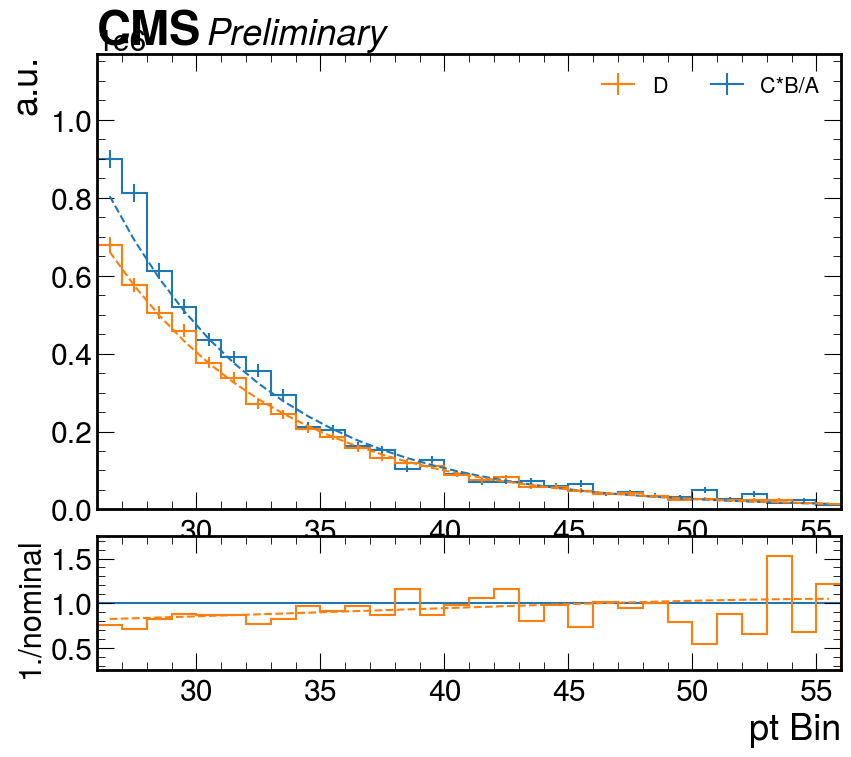

In [9]:
hratio = plot([hQCDFake_pt, hQCDSig_pt], labels=["C*B/A", "D"], name="QCD")
hratio[1].values()

[Hist(Regular(30, 26, 56, underflow=False, overflow=False, name='pt'), storage=Weight()) # Sum: WeightedSum(value=30, variance=1.12437),
 Hist(Regular(30, 26, 56, underflow=False, overflow=False, name='pt'), storage=Weight()) # Sum: WeightedSum(value=25.132, variance=0.531573),
 Hist(Regular(30, 26, 56, underflow=False, overflow=False, name='pt'), storage=Weight()) # Sum: WeightedSum(value=33.2493, variance=0.885185),
 Hist(Regular(30, 26, 56, underflow=False, overflow=False, name='pt'), storage=Weight()) # Sum: WeightedSum(value=25.4528, variance=0.811553)]

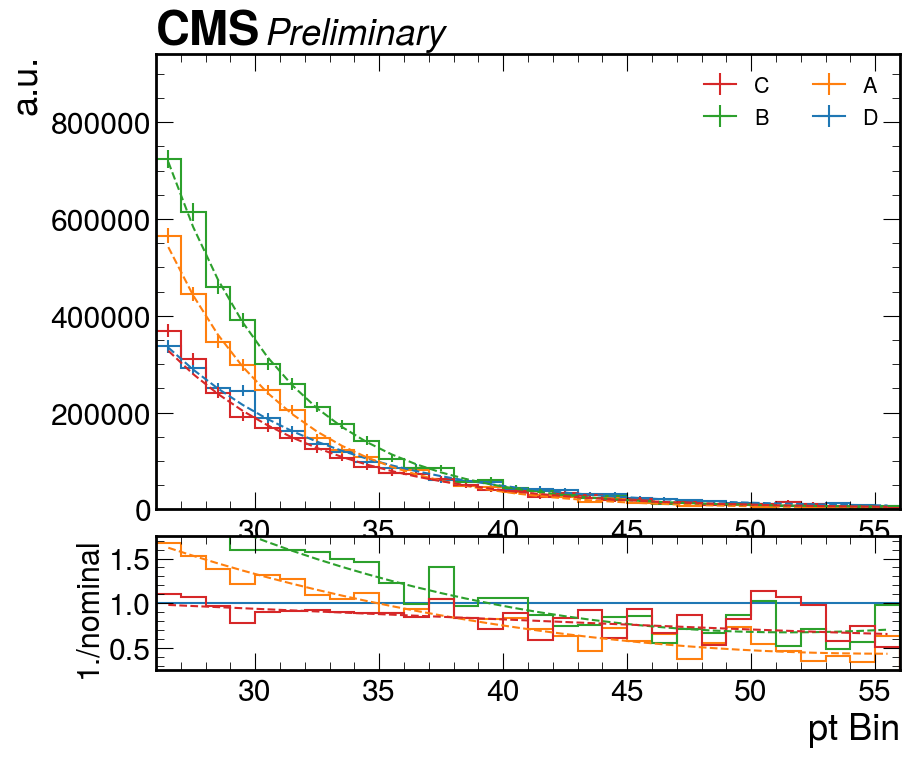

In [10]:
# plot fakes in each region separately
idx_c=0
idx_eta=0
hQCD_D = hQCD[{"charge":idx_c,"passIso":1,"passMT":1}]
hQCD_B = hQCD[{"charge":idx_c,"passIso":1,"passMT":0}]
hQCD_C = hQCD[{"charge":idx_c,"passIso":0,"passMT":1}]
hQCD_A = hQCD[{"charge":idx_c,"passIso":0,"passMT":0}]

hQCD_A_pt = hQCD_A.project("pt")
hQCD_B_pt = hQCD_B.project("pt")
hQCD_C_pt = hQCD_C.project("pt")
hQCD_D_pt = hQCD_D.project("pt")

hQCDFake_BA_pt = hh.divideHists(hQCD_B,hQCD_A).project("pt")
hQCDFake_CBA_pt = hh.multiplyHists(hQCD_C,hh.divideHists(hQCD_B,hQCD_A)).project("pt")

plot([hQCD_D_pt, hQCD_A_pt, hQCD_B_pt, hQCD_C_pt], labels=["D", "A", "B", "C"], name="QCD", ratio=True)

In [11]:
# plot fakes in each region separately
idx_c=0
hQCD_D = hQCD[{"charge":idx_c,"passIso":1,"passMT":1}]
hQCD_B = hQCD[{"charge":idx_c,"passIso":1,"passMT":0}]
hQCD_C = hQCD[{"charge":idx_c,"passIso":0,"passMT":1}]
hQCD_A = hQCD[{"charge":idx_c,"passIso":0,"passMT":0}]

hQCD_A_pt = hQCD_A.project("pt")
hQCD_B_pt = hQCD_B.project("pt")
hQCD_C_pt = hQCD_C.project("pt")
hQCD_D_pt = hQCD_D.project("pt")

[Hist(Regular(30, 26, 56, underflow=False, overflow=False, name='pt'), storage=Weight()) # Sum: WeightedSum(value=30, variance=1.12437),
 Hist(Regular(30, 26, 56, underflow=False, overflow=False, name='pt'), storage=Weight()) # Sum: WeightedSum(value=25.132, variance=0.531573),
 Hist(Regular(30, 26, 56, underflow=False, overflow=False, name='pt'), storage=Weight()) # Sum: WeightedSum(value=33.2493, variance=0.885185),
 Hist(Regular(30, 26, 56, underflow=False, overflow=False, name='pt'), storage=Weight()) # Sum: WeightedSum(value=25.4528, variance=0.811553)]

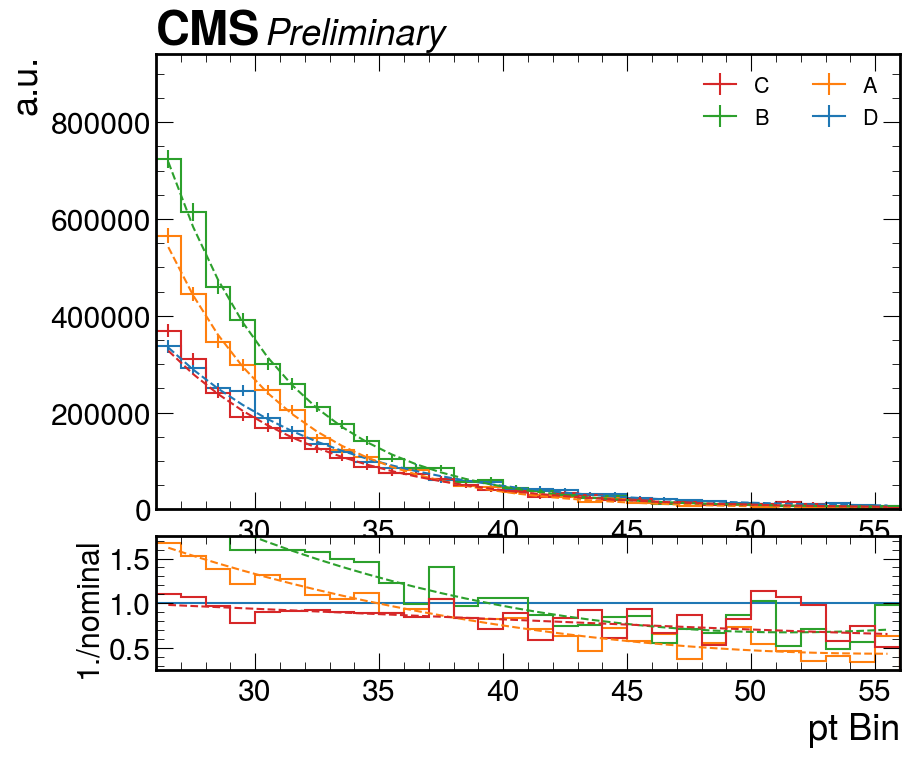

In [12]:
hQCDFake_BA_pt = hh.divideHists(hQCD_B,hQCD_A).project("pt")
hQCDFake_CBA_pt = hh.multiplyHists(hQCD_C,hh.divideHists(hQCD_B,hQCD_A)).project("pt")

plot([hQCD_D_pt, hQCD_A_pt, hQCD_B_pt, hQCD_C_pt], labels=["D", "A", "B", "C"], name="QCD", ratio=True)

[Hist(Regular(30, 26, 56, underflow=False, overflow=False, name='pt'), storage=Weight()) # Sum: WeightedSum(value=30, variance=1.12437),
 Hist(Regular(30, 26, 56, underflow=False, overflow=False, name='pt'), storage=Weight()) # Sum: WeightedSum(value=34.9131, variance=4.82999),
 Hist(Regular(30, 26, 56, underflow=False, overflow=False, name='pt'), storage=Weight()) # Sum: WeightedSum(value=34.9131, variance=4.82999)]

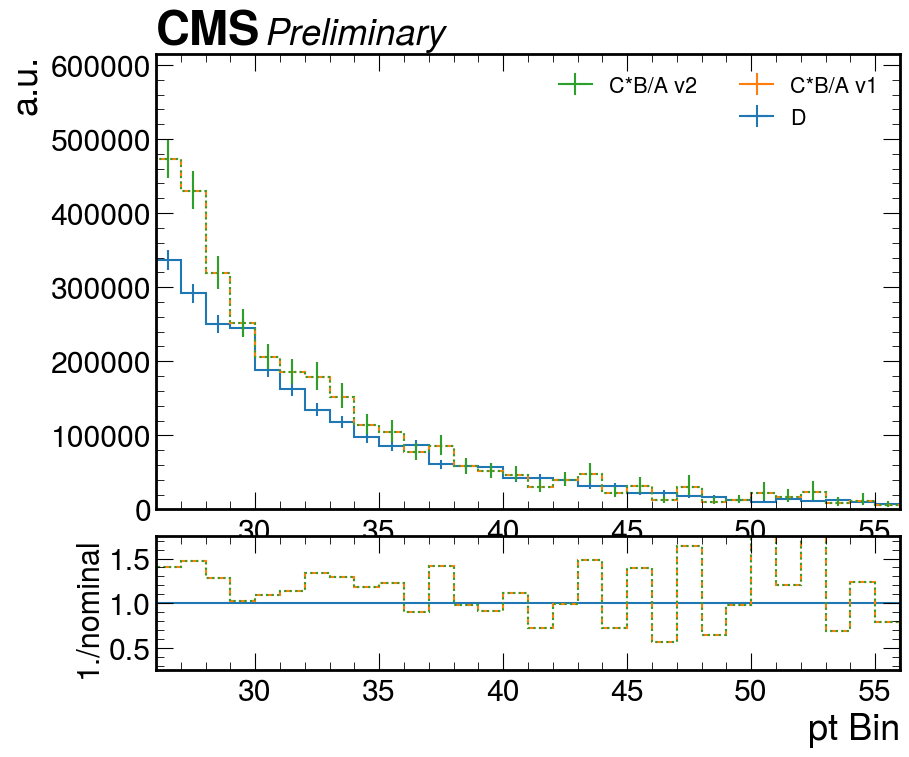

In [13]:
# compute fakes via ABCD directly here, not using wremnants functions, check numerical stability
hQCDFake_v1_pt = hh.multiplyHists(hQCD_C_pt,hh.divideHists(hQCD_B_pt,hQCD_A_pt))
hQCDFake_v2_pt = hh.divideHists(hh.multiplyHists(hQCD_C_pt,hQCD_B_pt),hQCD_A_pt)

plot([hQCD_D_pt, hQCDFake_v1_pt, hQCDFake_v2_pt], labels=["D", "C*B/A v1", "C*B/A v2"], name="QCD", fit=False, linestyles=["-","--", ":"])

In [14]:
import hist
def unrolledHist(h, obs=['pt', 'eta']):
    bins = np.multiply(*[len(a) for a in h.axes if a.name in obs])
    newh = hist.Hist(hist.axis.Regular(bins, 0, bins), storage=h.storage_type())
    newh[...] = np.ravel(h.project(*obs))
    return newh

[Hist(Regular(1440, 0, 1440, label='Axis 0'), storage=Weight()) # Sum: WeightedSum(value=1440, variance=938.297) (WeightedSum(value=1442, variance=938.297) with flow),
 Hist(Regular(1440, 0, 1440, label='Axis 0'), storage=Weight()) # Sum: WeightedSum(value=1755.33, variance=7246.01) (WeightedSum(value=1757.33, variance=7246.01) with flow)]

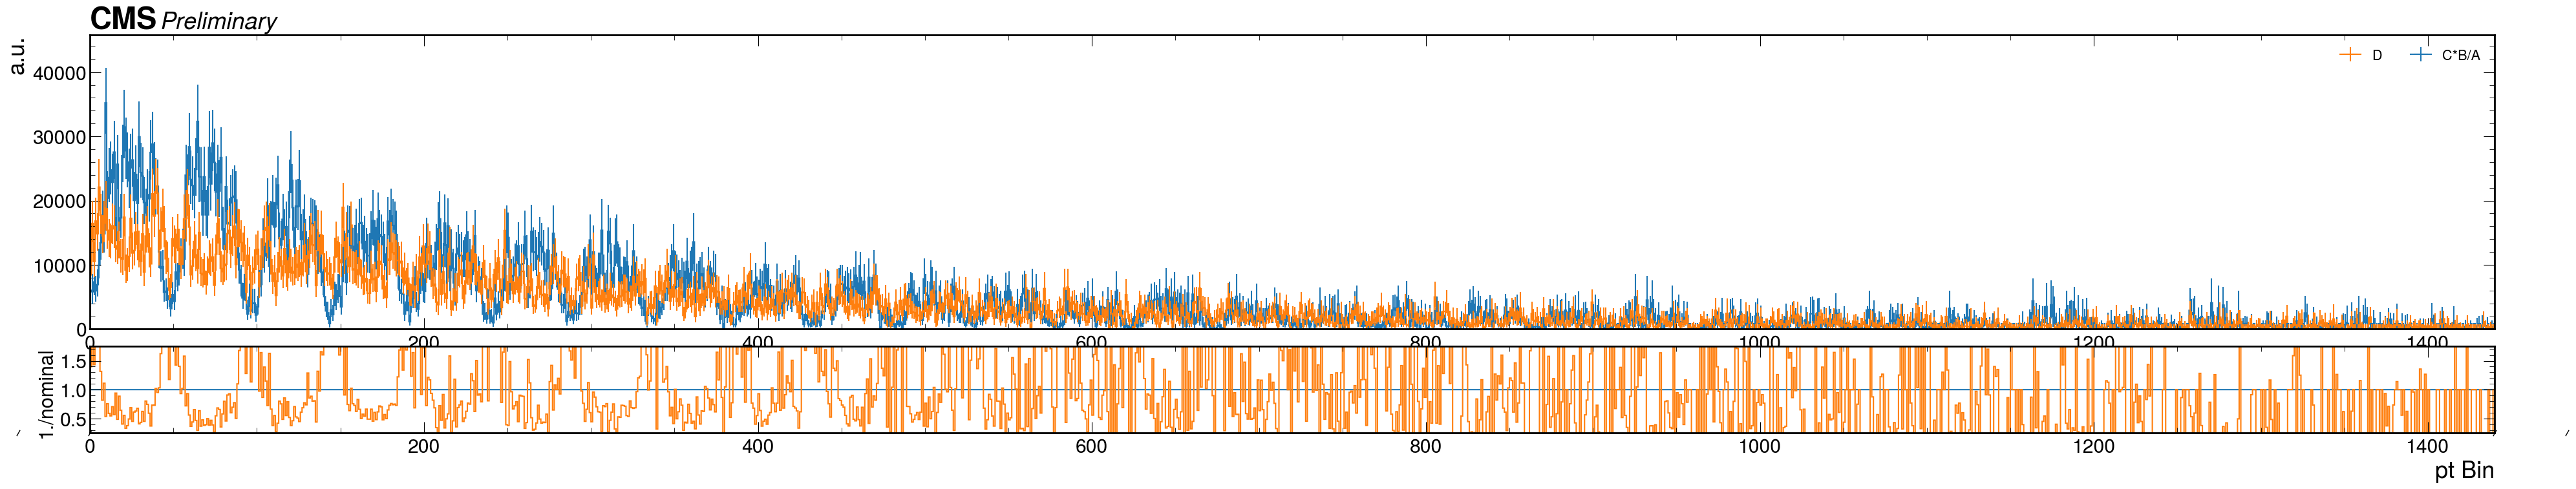

In [15]:
vars = "pt","eta"
h1ds = [unrolledHist(h, obs=vars) if len(vars) > 1 else h.project(*vars) for h in [hQCDFake, hQCDSig]]
plot(h1ds, ["C*B/A", "D"], name="QCD", fit=False)

In [16]:
def project(flow=False):
    # average over bins
    if flow:
        return lambda h, axes: h.project(*axes)/np.prod([a.extent for a in h.axes if a.name not in axes])
    else:
        return lambda h, axes: hh.projectNoFlow(h, axes)/np.prod([a.size for a in h.axes if a.name not in axes])

def make_plot_2d(h, name, proc, axes, corr=None, plot_error=False, clim=None, flow=True, density=False, log=False):
    
    h2d = project(flow)(h, axes)

    xlabel = styles.axis_labels.get(axes[0],axes[0])
    ylabel = styles.axis_labels.get(axes[1],axes[1])

    if flow:
        xedges, yedges = plot_tools.extendEdgesByFlow(h2d)
    else:
        edges = h2d.axes.edges
        xedges = np.reshape(edges[0], len(edges[0]))
        yedges = edges[1][0]

    if density:
        xbinwidths = np.diff(xedges)
        ybinwidths = np.diff(yedges)
        binwidths = np.outer(xbinwidths, ybinwidths) 
        h2d.values(flow=flow)[...] = h2d.values(flow=flow) / binwidths

    if plot_error:
        # plot relative errors instead
        h2d.values(flow=flow)[...] = np.sqrt(hh.relVariance(h2d.values(flow=flow), h2d.variances(flow=flow), fillOnes=True))

    # if args.xlim[0] is None:
    xlim = (xedges[0],xedges[-1])
    # else:
    #     xlim = args.xlim

    # if args.ylim[0] is None:
    ylim = (yedges[0],yedges[-1])
    # else:
    #     ylim = args.ylim

    fig, ax = plot_tools.figure(h2d, xlabel=xlabel, ylabel=ylabel, cms_label="Work in progress", automatic_scale=False, width_scale=1.2, xlim=xlim, ylim=ylim)

    if clim is None:
        if log:
            cmin = min(h2d.values(flow=flow)[h2d.values(flow=flow)>0]) # smallest value that is not 0
            cmax = h2d.values(flow=flow).max()
        else:
            cmin = max(0.95,h2d.values(flow=flow).min())
            cmax = min(1.05,h2d.values(flow=flow).max())
        # make symmetric range
        crange = max((cmax-1), (1-cmin))
        clim = [max(0.95,1-crange), min(1.05,1+crange)]
    else:
        colormesh = ax.pcolormesh(xedges, yedges, h2d.values(flow=flow).T, norm=LogNorm(vmin=clim[0], vmax=clim[1]), cmap=cm.RdBu)

    if log:
        colormesh = ax.pcolormesh(xedges, yedges, h2d.values(flow=flow).T, cmap=cm.RdBu, norm=LogNorm(vmin=clim[0], vmax=clim[1]))
    else:
        colormesh = ax.pcolormesh(xedges, yedges, h2d.values(flow=flow).T, cmap=cm.RdBu, vmin=clim[0], vmax=clim[1])

    cbar = fig.colorbar(colormesh, ax=ax)

    ax.text(1.0, 1.003, styles.text_dict.get(proc, proc), transform=ax.transAxes, fontsize=30,
            verticalalignment='bottom', horizontalalignment="right")

    # outfile = f"hist2d_{'_'.join(axes)}_{proc}_{name}"
    # if corr:
    #     outfile += f'_{corr.replace("(","").replace(")","")}'
    # if args.postfix:
    #     outfile += f"_{args.postfix}"
    # plot_tools.save_pdf_and_png(outdir, outfile)
    # plot_tools.write_index_and_log(outdir, outfile, args=args)
    plot_tools.save_pdf_and_png(output_dir, f"closure_fakes_2D_{name}")

In [19]:
# compute nonclosure in 3D (eta-pt-charge)
hQCDFake = sel.fakeHistABCD(hQCD, fakerate_integration_axes=[])
hQCDSig = sel.signalHistWmass(hQCD)

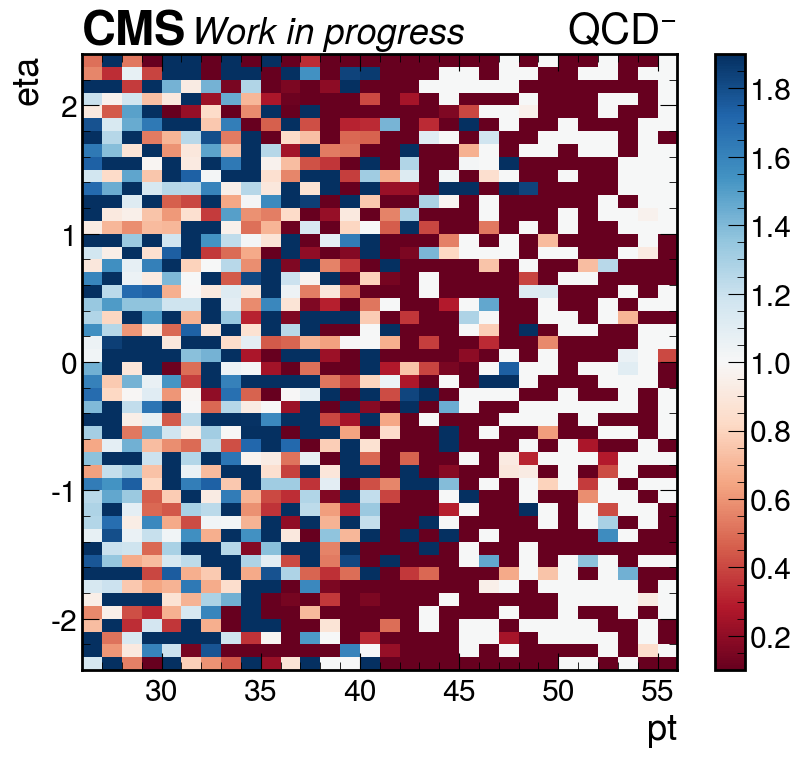

In [20]:
hQCDClosure = hh.divideHists(hQCDFake[{"charge":0}], hQCDSig[{"charge":0}])
make_plot_2d(hQCDClosure, "QCD_minus", "$QCD^{-}$", ["pt","eta"],clim=(0.1,1.9))

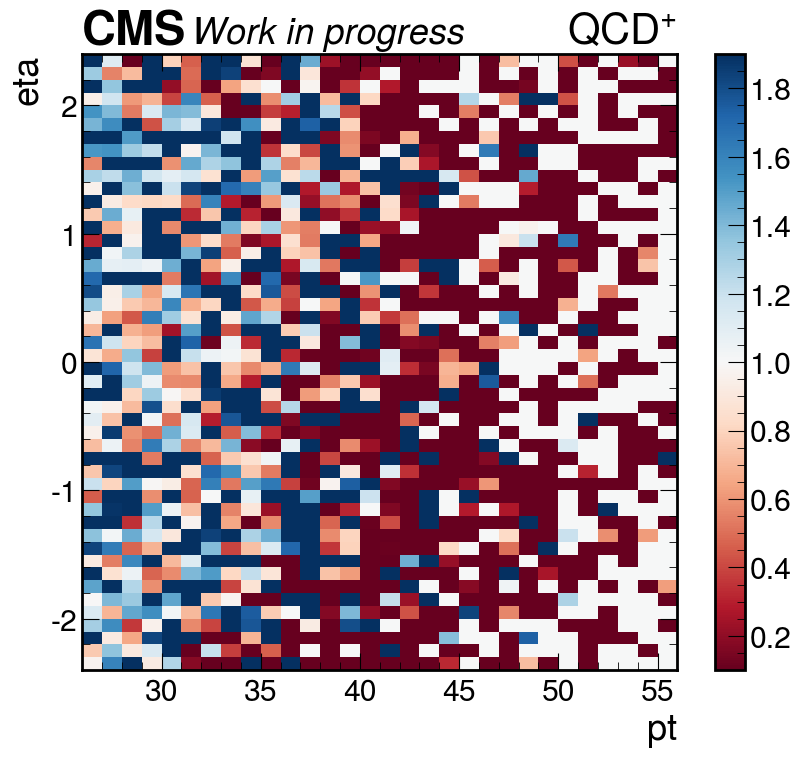

In [21]:
hQCDClosure = hh.divideHists(hQCDFake[{"charge":1}], hQCDSig[{"charge":1}])
make_plot_2d(hQCDClosure, "QCD_plus", "$QCD^{+}$", ["pt","eta"],clim=(0.1,1.9))